In [4]:
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob
import cv2
from natsort import natsorted

In [5]:
!nvcc --version
!nvidia-smi
use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

'nvcc' is not recognized as an internal or external command,
operable program or batch file.


Thu Dec 21 18:00:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.12       Driver Version: 472.12       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 N/A |                  N/A |
| 46%    0C    P8    N/A /  N/A |   1034MiB /  2048MiB |     N/A      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
images = glob("F:/instru_projects/test/*/*/*/*/*.tif")
masks = glob("F:/instru_projects/test/*/*/*/*/*.npy")




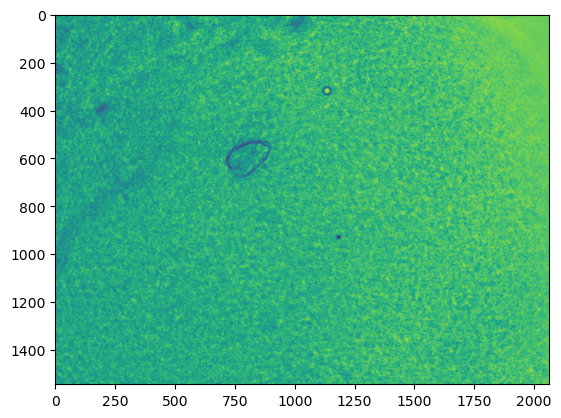

In [24]:
frame =  io.imread("F:/instru_projects/test/3/MCF10A/3mM/192h/10x_1.tif")

plt.imshow(frame[:,:,0])

In [25]:
images_filtered = []
masks_filtered = []

for i in range(len(images)):
    img_label = images[i][:-4]

    for k in range(len(masks)):
        mask_label = masks[k][:-8]
        if img_label == mask_label:
            try:
                seg = np.load(masks[k],allow_pickle=True).item()
                img = io.imread(images[i])
                if img.shape[-1] == 3:
                    img = img[:,:,0]
                img = np.stack((img, np.zeros_like(img)))
                img = img.transpose(1,2,0)
                images_filtered.append(img)
                masks_filtered.append(seg['masks'].squeeze())
                break
            except:
                print("failed ", images[i])
                break



In [15]:
len(images_filtered)

265

In [26]:
th = int(len(images_filtered)*4/5)

train_data = images_filtered[:th]
train_labels = masks_filtered[:th]

test_data = images_filtered[th:]
test_labels = masks_filtered[th:]

C:\Users\Arttu\AppData\Local\Temp\ipykernel_12072\3689463034.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


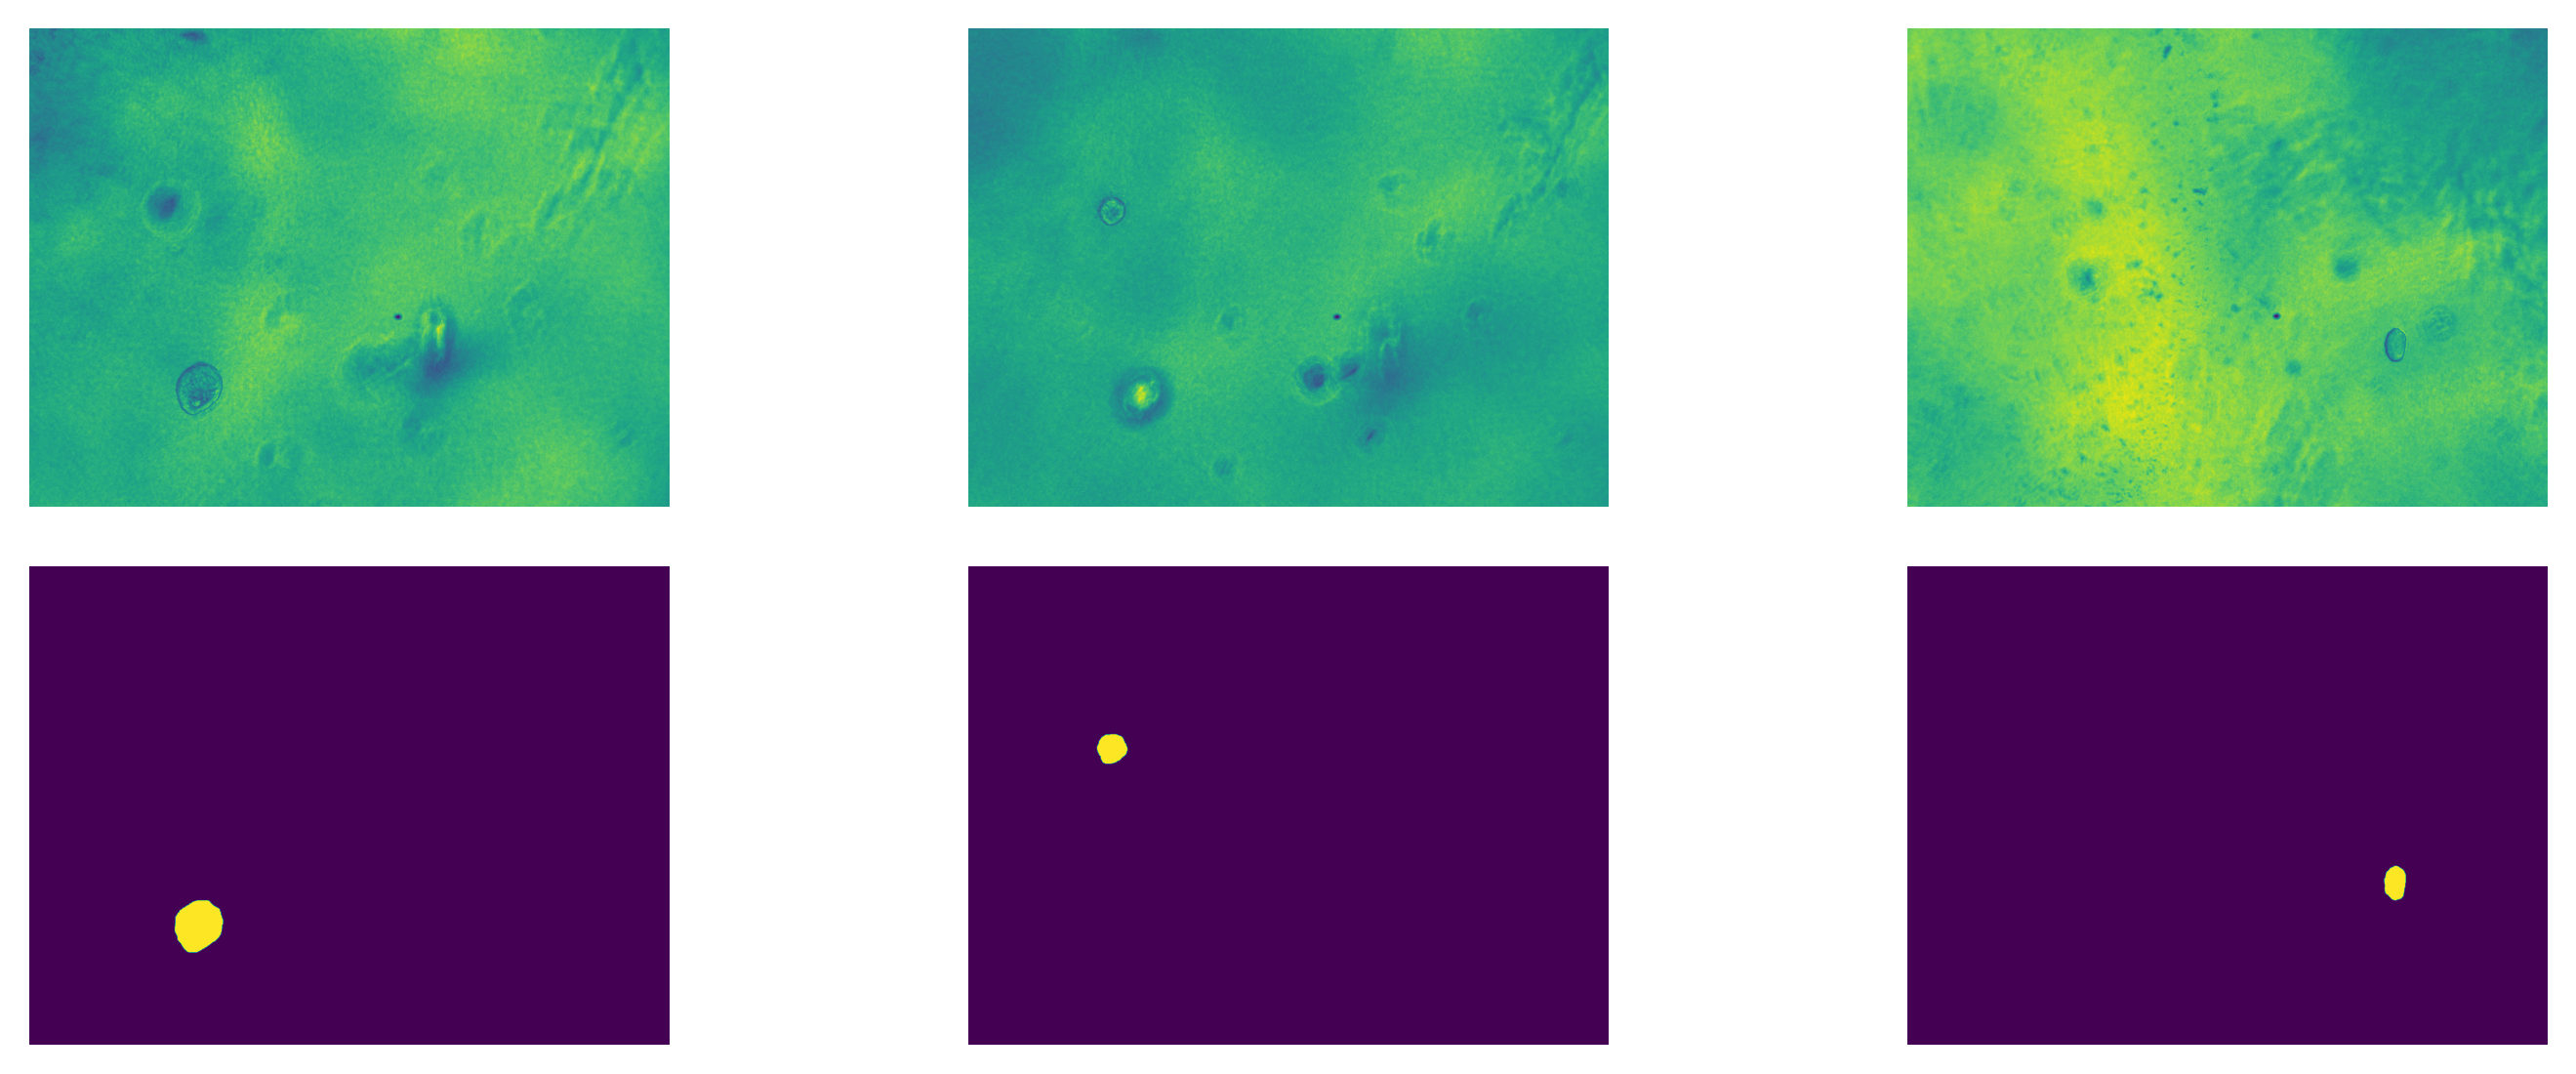

In [27]:
index = 3
plt.figure(figsize=(10,4), dpi =300)
for k,f in enumerate(train_data[:index]):
    img = f
    plt.subplot(2,len(train_data[:index]),k+1)
    #img = img.transpose(1,2,0)
    plt.imshow(img[:,:,0])
    plt.axis('off')

    plt.subplot(2,len(train_data[:index]),len(train_data[:index]) + k+1)
    #seg = np.load(os.path.splitext(f)[0] + '_seg.npy', allow_pickle=True).item()
    #masks= seg['masks'].squeeze()
    masks = train_labels[k]
    plt.tight_layout()
    plt.imshow(masks)
    plt.axis('off')

In [41]:


#@markdown ###Path to images and masks:

train_dir = "F:/instru_project/timeseries/" #@param {type:"string"}
#test_dir = "D:/instruData/imgs/1/mcf10a/2mgml/24h" #@param {type:"string"}

#Define where the patch file will be saved
base = "./content"

# model name and path
#@markdown ###Name of the pretrained model to start from and new model name:
from cellpose import models

initial_model = "LC1" #@param ['cyto','nuclei','tissuenet','livecell','cyto2','CP','CPx','TN1','TN2','TN3','LC1','LC2','LC3','LC4','scratch']
model_name = "model_test" #@param {type:"string"}

# other parameters for training.
#@markdown ###Training Parameters:
#@markdown Number of epochs:
n_epochs =  30 #@param {type:"number"}

Channel_to_use_for_training = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you have a secondary channel that can be used for training, for instance nuclei, choose it here:
Second_training_channel= "None" #@param ["None", "Blue", "Green", "Red"]

#@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = True #@param {type:"boolean"}

#@markdown ###If not, please input:
learning_rate = 0.1 #@param {type:"number"}
weight_decay = 0.0001 #@param {type:"number"}

if (Use_Default_Advanced_Parameters): 
  print("Default advanced parameters enabled")
  learning_rate = 0.1 
  weight_decay = 0.0001
  
#here we check that no model with the same name already exist, if so delete
model_path = './models/'

if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")
  
test_dir = None

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1


if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model =='scratch':
  initial_model = 'None'



Default advanced parameters enabled


In [42]:
model

In [43]:


run_str = f'python -m cellpose --use_gpu --verbose --train --pretrained_model {initial_model} --chan {chan} --chan2 {chan2} --n_epochs {n_epochs} --learning_rate {learning_rate} --weight_decay {weight_decay}'
if test_dir is not None:
    run_str += f' --test_dir {test_dir}'
run_str += ' --mask_filter _seg.npy' # if you want to use _seg.npy files for training
print(run_str)



python -m cellpose --use_gpu --verbose --train --dir F:/instru_project/timeseries/ --pretrained_model LC2 --chan 0 --chan2 0 --n_epochs 30 --learning_rate 0.1 --weight_decay 0.0001 --mask_filter _seg.npy


In [44]:


# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model) #model_type=initial_model), 

# set channels
channels = [chan, chan2]

# get files
#output = io.load_train_test_data(train_dir, test_dir, mask_filter='_seg.npy')
#train_data, train_labels, _, test_data, test_labels, _ = output

new_model_path = model.train(train_data, train_labels, 
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=channels, 
                              save_path=model_path, 
                              n_epochs=n_epochs,
                              learning_rate=learning_rate, 
                              weight_decay=weight_decay, 
                              nimg_per_epoch=8,
                              model_name=model_name)

# diameter of labels in training images
diam_labels = model.diam_labels.copy()



creating new log file
2023-12-21 21:45:21,115 [INFO] WRITING LOG OUTPUT TO C:\Users\Arttu\.cellpose\run.log
2023-12-21 21:45:21,116 [INFO] 
cellpose version: 	2.2.3 
platform:       	win32 
python version: 	3.8.18 
torch version:  	2.1.2+cpu
2023-12-21 21:45:21,118 [INFO] >> LC2 << model set to be used
2023-12-21 21:45:21,120 [INFO] >>>> using CPU
2023-12-21 21:45:21,398 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2023-12-21 21:47:34,498 [INFO] computing flows for labels


 40%|███████████████████████████████▉                                                | 111/278 [20:53<02:38,  1.05it/s]

2023-12-21 22:09:00,753 [WARNING] empty masks!


 45%|███████████████████████████████████▋                                            | 124/278 [21:05<02:43,  1.06s/it]

2023-12-21 22:09:12,937 [WARNING] empty masks!


 46%|█████████████████████████████████████                                           | 129/278 [21:09<02:04,  1.20it/s]

2023-12-21 22:09:16,742 [WARNING] empty masks!


 70%|███████████████████████████████████████████████████████▊                        | 194/278 [40:38<00:47,  1.77it/s]

2023-12-21 22:28:46,464 [WARNING] empty masks!


 87%|█████████████████████████████████████████████████████████████████████▎          | 241/278 [41:24<00:58,  1.58s/it]

2023-12-21 22:29:32,219 [WARNING] empty masks!


100%|████████████████████████████████████████████████████████████████████████████████| 278/278 [41:58<00:00,  9.06s/it]


2023-12-21 22:31:32,480 [INFO] computing flows for labels


 67%|███████████████████████████████████████████████████████                           | 47/70 [25:18<03:26,  8.96s/it]

2023-12-21 22:56:53,806 [WARNING] empty masks!


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [25:30<00:00, 21.87s/it]


2023-12-21 22:57:14,804 [WARNING] 238 train images with number of masks less than min_train_masks (5), removing from train set


C:\Users\Arttu\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Arttu\Anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2023-12-21 22:57:22,444 [INFO] >>>> median diameter set to = 30
2023-12-21 22:57:22,459 [INFO] >>>> mean of training label mask diameters (saved to model) 94.515
2023-12-21 22:57:22,547 [INFO] >>>> training network with 2 channel input <<<<
2023-12-21 22:57:22,549 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2023-12-21 22:57:22,550 [INFO] >>>> ntrain = 40, ntest = 70
2023-12-21 22:57:22,656 [INFO] >>>> nimg_per_epoch = 40
2023-12-21 22:59:00,309 [INFO] Epoch 0, Time 97.8s, Loss 1.0660, Loss Test 0.6102, LR 0.0000
2023-12-21 22:59:47,146 [INFO] saving network parameters to F:/instru_project/timeseries/models/models/model_test
2023-12-21 23:03:24,537 [INFO] Epoch 5, Time 362.0s, Loss 0.3912, Loss Test 0.2528, LR 0.0556
2023-12-21 23:07:43,304 [INFO] Epoch 10, Time 620.8s, Loss 0.2230, Loss Test 0.2047, LR 0.1000
2023-12-21 23:15:54,254 [INFO] Epoch 20, Time 1111.7s, Loss 0.1577, Loss Test 0.1699, LR 0.1000
2023-12-21 23:22:47,806 [INFO] saving network parameters to F:/in

In [45]:
# get files (during training, test_data is transformed so we will load it again)
#output = io.load_train_test_data(test_dir, mask_filter='_seg.npy')
#test_data, test_labels = output[:2]

# run model on test images
masks = model.eval(test_data, 
                   channels=[chan, chan2],
                   diameter=diam_labels)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')



2023-12-21 23:25:40,160 [INFO] 16%|#5        | 11/70 [02:44<14:03, 14.30s/it]
2023-12-21 23:25:44,264 [INFO] No cell pixels found.
2023-12-21 23:44:21,279 [INFO] 100%|##########| 70/70 [21:25<00:00, 18.37s/it]

>>> average precision at iou threshold 0.5 = 0.357


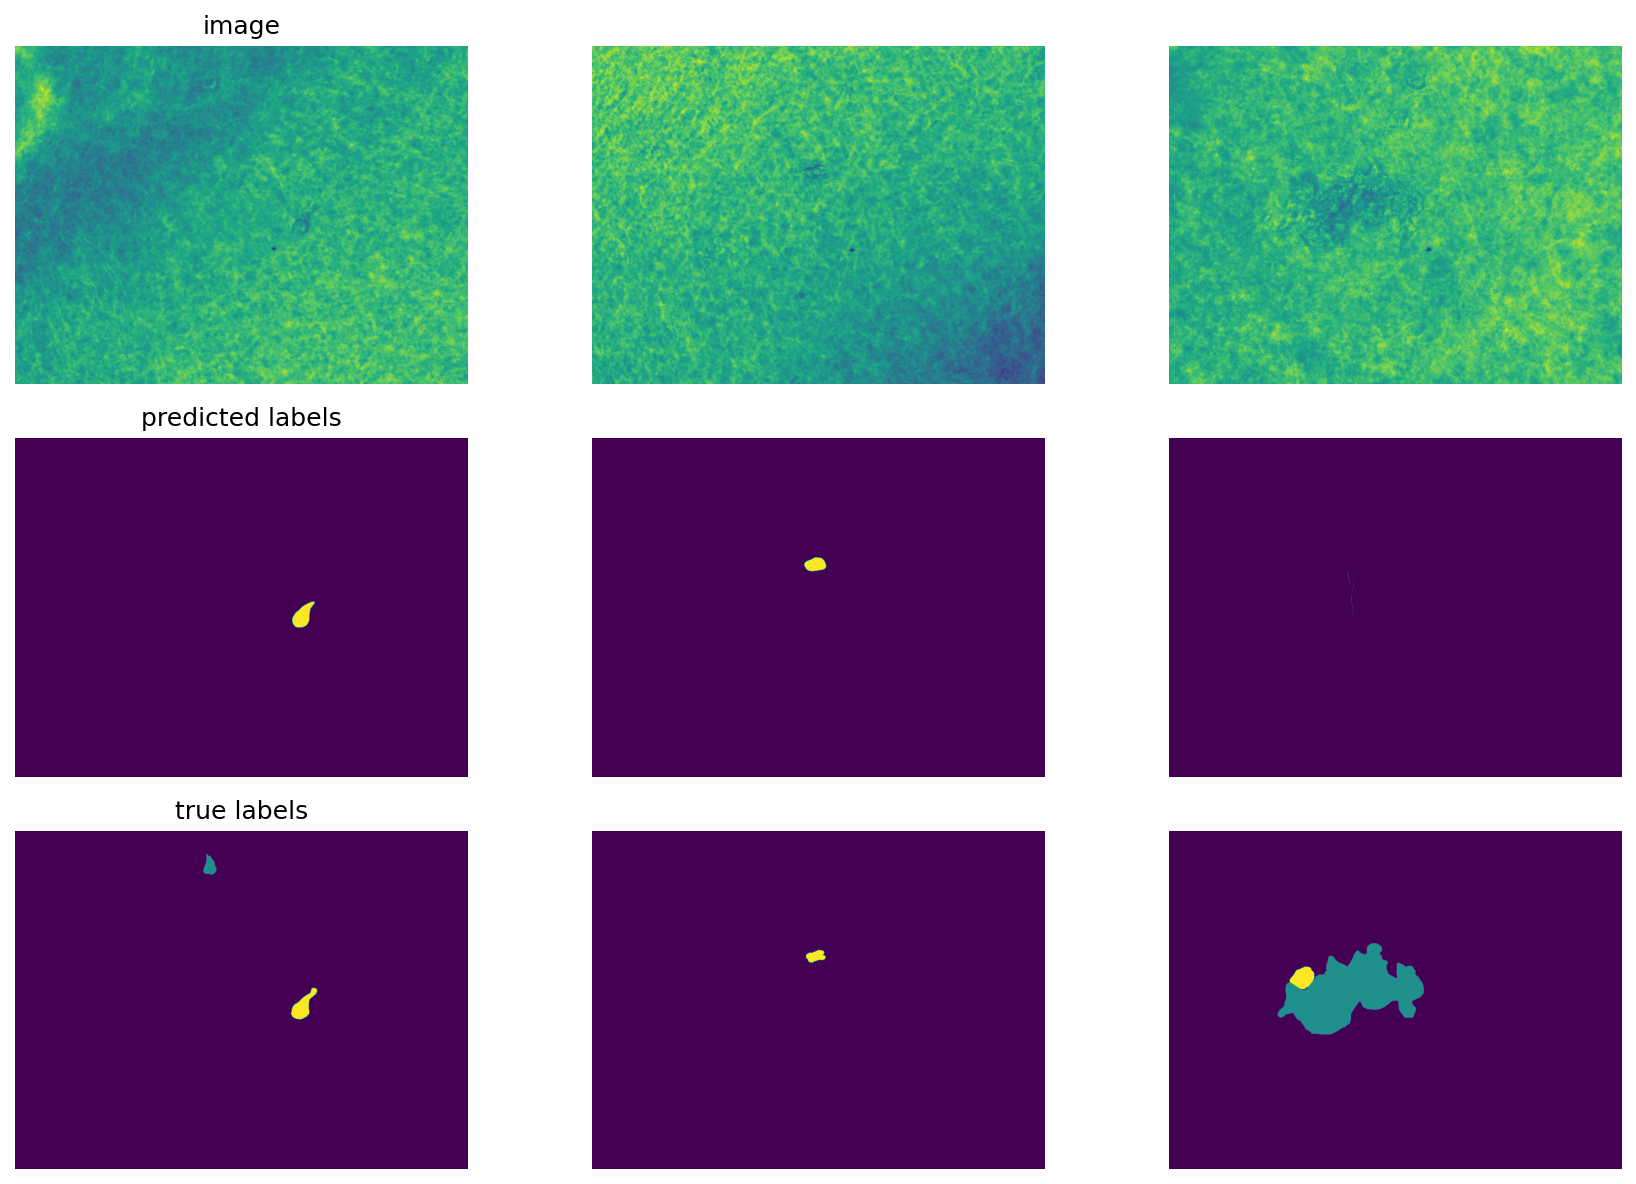

In [46]:
index = 3

plt.figure(figsize=(12,8), dpi=150)
for k,im in enumerate(test_data[:index]):
    img = im.transpose((1,2,0)).copy()
    plt.subplot(3,len(test_data[:index]), k+1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    if k==0:
        plt.title('image')

    plt.subplot(3,len(test_data[:index]), len(test_data[:index]) + k+1)
    plt.imshow(masks[k])
    plt.axis('off')
    if k==0:
        plt.title('predicted labels')

    plt.subplot(3,len(test_data[:index]), 2*len(test_data[:index]) + k+1)
    plt.imshow(test_labels[k])
    plt.axis('off')
    if k==0:
        plt.title('true labels')
plt.tight_layout()

